In [1]:
import sys
sys.path.append('../Scapade')

from fitbert import FitBert

from pathlib import Path
from symspellpy_scapade import symspellscapade
import pkg_resources
import pandas as pd
import warnings

from spellchecker import SpellChecker

from pathlib import Path


warnings.simplefilter('ignore')


from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
# Load S-capade method - only need to do this once, this takes the longest time at outset
SymSpell = symspellscapade.SymSpell
Verbosity = symspellscapade.Verbosity
scapade = SymSpell(max_dictionary_edit_distance=2, prefix_length=15)
dictionary_path = pkg_resources.resource_filename("symspellpy_scapade", "cmu_frequency_added.csv")
scapade.load_dictionary(dictionary_path, term_index=1, count_index=2)

def correction(scapade, phoneme_sequence):
    misspelling = phoneme_sequence
    suggestions = scapade.lookup(misspelling, Verbosity.ALL)
    input_path_csv = Path.cwd().parent / "Scapade" / "symspellpy_scapade" / "cmu_frequency_added.csv"
    df = pd.read_csv(input_path_csv, names=['word', 'seq', 'count'])
    correction_dict =  {misspelling:{"suggested_correction":"", "candidates":[]}}

    for suggestion in suggestions:
        if len(correction_dict[misspelling]['candidates']) >= 10:
            break
        current_seq = str(suggestion).split(',')[0]
        df_slice = df[df['seq'] == current_seq].sort_values(by=['count'], ascending=False)
        if correction_dict[misspelling]['suggested_correction'] == '' and df_slice.iloc[0]['count'] >= 1:
            correction_dict[misspelling]['suggested_correction'] = df_slice.iloc[0]['word']
        if len(correction_dict[misspelling]['suggested_correction']) > 0 and \
        len(correction_dict[misspelling]['candidates']) <= 10:
            df_slice = df_slice[df_slice['count'] > 1]
            correction_dict[misspelling]['candidates'] += (list(df_slice[:5]['word']))
    return correction_dict

In [3]:
def generate_scapade_candidates(phoneme_seq):
    scapade_candidates = correction(scapade, phoneme_seq)[phoneme_seq]['candidates']
    return scapade_candidates

spell = SpellChecker()
def generate_pyspell_candidates(misspelling):
    pyspell_candidates = spell.candidates(misspelling)
    return list(pyspell_candidates)

In [4]:
# Initializing FitBert is a bit slow, so this makes sure it's only done once
if "fb" not in globals():
    fb = FitBert()
    
    
def rank_candidates(row, candidates_col_name, masked_string_col_name):
    """ 
    Use FitBert to rank a list of candidates in a given context
    
    Assumed to be used with the df.apply() method
    
    Args:
    row: a row in a DataFrame
    candidates_col_name: the name of the column containing a list of candidates
    masked_string_col_name: the name of the column containing the context
    
    Returns a list of candidates sorted by ranking (best ranked first)
    
    """
    candidates = row[candidates_col_name]
    masked_string = row[masked_string_col_name]
    
    ranked_options = fb.rank(masked_string, options=candidates, delemmatize=False)
    
    return ranked_options

device: cpu
using model: bert-large-uncased


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The input csv (at `csv_path`), should have the format as below, with the same column names.
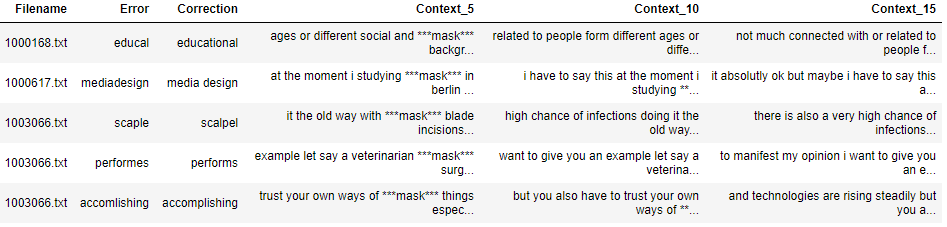


The txt file at `phoneme_path` should have the following format, as output by g2p-seq2seq.

|  |
| ---  |
| educal EH JH AH K AH L |
| mediadesign M IY D IY AH D EH Z IH G N |
| scaple S K EY P AH L |
| performes P ER F AO R M Z |
| accomlishing AH K AA M L IH SH IH NG |

In [5]:
language_code = "ZHO" 
file_path = Path.cwd().parent / "Data" / language_code

csv_file_name = f"{language_code}_errors_clean.csv"
phoneme_file_name = f"{language_code}_phonemes.txt"


df = pd.read_csv(file_path / csv_file_name)


df = df[["Error","Correction","Context_15"]]
df = df.rename({'Context_15':'Masked Context'}, axis=1)

phonemes_df = pd.read_csv(file_path + phoneme_file_name, header=None)

# Split the phoneme file at the first occurence of a space
df['Phoneme Seq'] = phonemes_df[0].apply(lambda x : x.split(' ', 1)[1])

df

,Error,Correction,Masked Context,Phoneme Seq
0,experence,experience,upcoming of beijing olympic 2008 many sports a...,EH K S P EH R AH N S
1,attand,attend,unique sports in the world therefore there are...,AH T AE N D
2,comptetive,competive,than older people do besides young people have...,K AA M P T AH T IH V
3,peolpe,people,standing on the crossroad in this turning poin...,P IY OW L P IY
4,varity,variety,people enjoy life more than old peolpe do beca...,V EH R IH T IY
...,...,...,...,...
5958,explicte,explain,not enjoy life more than old people in the fol...,IH K S P L IH K T
5959,lanch,launch,with their operating system from windows 95 wi...,L AE N CH
5960,provied,provide,they were not satisfied what they already got ...,P R UW V IY D
5961,repuations,reputations,technologies to the public in a more flexible ...,R EH P Y AH W EY SH AH N Z


<b>The following 2 cells may take several hours to run  if the dataset is large.</b>

In [6]:
print('Getting S-Capade Candidates...')

# progress_apply() is the same as apply(), but shows a nice progress bar.
df['S-Capade Candidates'] = df['Phoneme Seq'].progress_apply(generate_scapade_candidates)

print('Done.')

print('Getting PySpell Candidates...')
df['PySpell Candidates'] =  df['Error'].progress_apply(generate_pyspell_candidates)
print('Done.')

print('Getting combined Candidates...')
df['Combined Candidates'] =  df.progress_apply(lambda x : list(set(x['S-Capade Candidates']) | set(x['PySpell Candidates'])),
                                               axis=1)
print('Done.')

Getting S-Capade Candidates...


  0%|          | 0/5963 [00:00<?, ?it/s]

Done.
Getting PySpell Candidates...


  0%|          | 0/5963 [00:00<?, ?it/s]

Done.
Getting combined Candidates...


  0%|          | 0/5963 [00:00<?, ?it/s]

Done.


In [7]:
print('Ranking S-Capade Candidates...')
df['S-Capade Ranked'] = df.progress_apply(rank_candidates, args=('S-Capade Candidates', 'Masked Context'),
                                               axis=1)
print('Done.')

print('Ranking PySpell Candidates...')
df['PySpell Ranked'] =  df.progress_apply(rank_candidates, args=('PySpell Candidates', 'Masked Context'),
                                               axis=1)
print('Done.')

print('Ranking Combined Candidates...')
df['Combined Ranked'] =  df.progress_apply(rank_candidates, args=('Combined Candidates', 'Masked Context'),
                                               axis=1)
print('Done.')

Ranking S-Capade Candidates...


  0%|          | 0/5963 [00:00<?, ?it/s]

Done.
Ranking PySpell Candidates...


  0%|          | 0/5963 [00:00<?, ?it/s]

Done.
Ranking Combined Candidates...


  0%|          | 0/5963 [00:00<?, ?it/s]

Done.


In [10]:
df

,Error,Correction,Masked Context,Phoneme Seq,S-Capade Candidates,PySpell Candidates,Combined Candidates,S-Capade Ranked,PySpell Ranked,Combined Ranked
0,experence,experience,upcoming of beijing olympic 2008 many sports a...,EH K S P EH R AH N S,[],[experience],[experience],[],[experience],[experience]
1,attand,attend,unique sports in the world therefore there are...,AH T AE N D,"[attend, attained, attuned, stand, attainder, ...",[attend],"[strand, stander, append, attainder, tend, att...","[attend, stander, stand, attainder, tend, attu...",[attend],"[attend, stander, stand, attainder, tend, attu..."
2,comptetive,competive,than older people do besides young people have...,K AA M P T AH T IH V,"[competitive, competent, competence]",[competitive],"[competent, competitive, competence]","[competitive, competent, competence]",[competitive],"[competitive, competent, competence]"
3,peolpe,people,standing on the crossroad in this turning poin...,P IY OW L P IY,"[parolee, parolees, poultry]",[people],"[parolees, people, parolee, poultry]","[poultry, parolees, parolee]",[people],"[people, poultry, parolees, parolee]"
4,varity,variety,people enjoy life more than old peolpe do beca...,V EH R IH T IY,"[verity, verity, charity, rarity, verdi, vanit...","[verity, parity, variety, rarity, varsity, van...","[verity, parity, variety, rarity, verdi, levit...","[verity, charity, rarity, merits, parity, vani...","[variety, verity, varsity, rarity, parity, van...","[variety, verity, varsity, charity, rarity, me..."
...,...,...,...,...,...,...,...,...,...,...
5958,explicte,explain,not enjoy life more than old people in the fol...,IH K S P L IH K T,"[expect, explicit, extinct, expelling]",[explicate],"[explicate, extinct, expelling, expect, explicit]","[explicit, expect, expelling, extinct]",[explicate],"[explicit, expect, explicate, expelling, extinct]"
5959,lanch,launch,with their operating system from windows 95 wi...,L AE N CH,"[lynch, ranch, lunch, lance, launch, land, lan...","[panch, lunch, ranch, lanc, lynch, larch, latc...","[panch, lunch, ranch, lanc, larch, rancher, bl...","[launch, land, lance, lanny, lunch, ranch, ran...","[launch, lance, panch, lanc, lancs, larch, lun...","[launch, land, lance, panch, lanc, lancs, lann..."
5960,provied,provide,they were not satisfied what they already got ...,P R UW V IY D,"[proofread, proved, provide, prudery, proving,...","[provided, provide, proxied, proved]","[provided, precede, proved, proceed, provide, ...","[provide, approves, proving, proofread, proved...","[provide, provided, proved, proxied]","[provide, provided, approves, proving, proofre..."
5961,repuations,reputations,technologies to the public in a more flexible ...,R EH P Y AH W EY SH AH N Z,"[reputations, regulations, reputation]",[reputations],"[regulations, reputation, reputations]","[reputation, reputations, regulations]",[reputations],"[reputation, reputations, regulations]"


In [14]:

output_file_name = f"{language_code}_errors_with_candidates.csv"

df.to_csv(file_path / output_file_name, index=False)